# Neural & Behavioral Modeling - Week 8 (Exercises)
by 李彥廷 (b08207008@ntu.edu.tw)

In [1]:
%config IPCompleter.greedy=True 
%matplotlib inline
from numpy import *
from matplotlib.pyplot import *
from IPython.display import *

## 1 InStar Learning (4 points)
Try to replicate Fig.2 of <a href=https://arxiv.org/pdf/1612.03270.pdf>[1]</a> = Fig. 3A of <a href=https://sci-hub.se/10.1126/science.1212003>[2]</a>:

[1] Huang, T. R. (2016). Hebbian plasticity for improving perceptual decisions. arXiv preprint arXiv:1612.03270.

[2] Shibata, K., Watanabe, T., Sasaki, Y., & Kawato, M. (2011). Perceptual learning incepted by decoded fMRI neurofeedback without stimulus presentation. Science, 334(6061), 1413-1415.

In [2]:
p=array([ # try replacing -1 to 0
    
    [1,0, 1,
     1,0, 1,
     1,0, 1], # 3x3 pattern 1 
    
    [0, 1, 1,
      1,0, 1,
      1, 1,0], # 3x3 pattern 2
    
    [ 1, 1,0,
      1,0, 1,
     0, 1, 1],   # 3x3 pattern 3
])

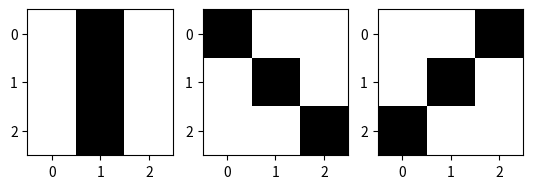

In [3]:
for i in range(3):
    subplot(2,3,i+1);
    imshow(p[i].reshape((3,3)),cmap='gray')

In [4]:
def unit_vector(vector):
    return vector / np.linalg.norm(vector)

在test中，將pattern加上不同量的noise來當作input，分別跟三個y做內積，最大的那個代表activate的，會當作回答的答案。

In [5]:
def test(snr, ws):
    lst = [[],[],[]]
    for i in range(150):
        r = i%3
        xs = p + snr * random.normal(size=(3,9))
        current_x = unit_vector(xs[r])
        unit_ws = [unit_vector(w) for w in ws]
        y1 = dot(unit_ws[0],current_x)
        y2 = dot(unit_ws[1],current_x)
        y3 = dot(unit_ws[2],current_x)
        ys = array([y1,y2,y3])
        ans = ys.argmax(axis=0)
        lst[r].append(ans==r)
    
    acclist = list(map(mean,lst))
    
    return acclist

learning 是將x這個input設定為pattern 2，然後透過instar learning來學習該pattern。最後w2會很接近pattern 2  
這裡有將x跟w都轉成單位向量，以免y>1，也就是y會是x和w的cosine similarity

In [6]:
# Instar learning:
def learning(ws):
#     print('pre',ws[1])
    for i in range(1500): # trials 
        x = p[1]
        unit_x = unit_vector(x)
        unit_ws = [unit_vector(w) for w in ws]
        y1 = dot(unit_ws[0],unit_x)
        y2 = dot(unit_ws[1],unit_x)
        y3 = dot(unit_ws[2],unit_x)
        ys = array([y1,y2,y3])
        largest = ys.argmax(axis=0)
        ws[largest]=ws[largest]+ys[largest]*(x-ws[largest]) # postsynaptically gated InStar
#     print('post',ws[1]) 
    return ws

每個受試者有對三個pattern的weight，對應到不同的orientation再加上一點noise，沒有用完全隨機的原因是這樣才能在test上不會是隨機的表現，而加上一點隨機是為了讓之後learning還有空間可以進步。  
整個simulation會先進行pretest，再針對pattern 2來學習，最後再做一次posttest
這個simulation共有20個受試者。

In [7]:
def Subject():
    snrlist = [2,1.2,0.5,0.3]
    w1 = p[0] + 0.3*random.normal(size=9)
    w2 = p[1] + 0.3*random.normal(size=9)
    w3 = p[2] + 0.3*random.normal(size=9)
    ws = [w1,w2,w3]

    pretest = []
    for snr in snrlist:
        pretest.append(test(snr, ws))
    pretest = array(pretest).T  
    ws = learning(ws)

    postest = []
    for snr in snrlist:
        postest.append(test(snr,ws))
    postest = array(postest).T  
    return pretest, postest

In [8]:
p1 = [[],[]]
p2 = [[],[]]
p3 = [[],[]]
for i in range(20):
    pre, post = Subject()
    p1[0].append(pre[0])
    p1[1].append(post[0])
    p2[0].append(pre[1])
    p2[1].append(post[1])
    p3[0].append(pre[2])
    p3[1].append(post[2])

In [9]:
p1pre = array(p1[0])
p1post = array(p1[1])
p2pre = array(p2[0])
p2post = array(p2[1])
p3pre = array(p3[0])
p3post = array(p3[1])

結果可以發現，只有有經過learning的pattern在posttest的表現比pretest好

# Pattern 1

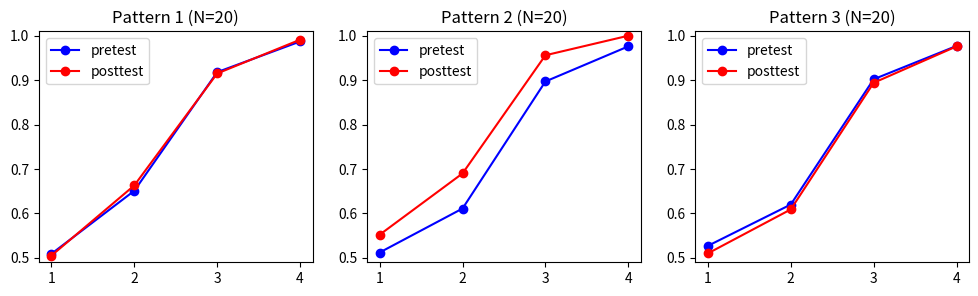

In [10]:
fig, axs = subplots(1,3,figsize=(12,3))
axs[0].plot([1,2,3,4],p1pre.mean(axis=0),'o-',color='b')
axs[0].plot([1,2,3,4],p1post.mean(axis=0),'o-',color='r')
axs[1].plot([1,2,3,4],p2pre.mean(axis=0),'o-',color='b')
axs[1].plot([1,2,3,4],p2post.mean(axis=0),'o-',color='r')
axs[2].plot([1,2,3,4],p3pre.mean(axis=0),'o-',color='b')
axs[2].plot([1,2,3,4],p3post.mean(axis=0),'o-',color='r')
i=0
for ax in axs:
    i+=1
    ax.set_ylim(0.49, 1.01)
    ax.legend(['pretest','posttest'])
    ax.set_title(f'Pattern {i} (N=20)')

## 2 PyTorch (4 points)
Read <a href="https://www.pytorchtutorial.com/pytorch-for-numpy-users/">this tutorial</a> first and port the following Instar Learning from NumPy to PyTorch:

In [11]:
# Instar learning:
x=array([0.1,0.3,0.6])
W=random.rand(3)
for i in range(10): # trials 
    y=dot(W,x) 
    W+=y*(x-W) # postsynaptically gated InStar 
    print(W,y)

[0.55886646 0.29265716 0.46735114] 0.4001431746844597
[0.36426373 0.29577122 0.52360679] 0.42409447479275314
[0.24816691 0.29762901 0.55716799] 0.4393218096476784
[0.18172795 0.29869218 0.57637413] 0.4484061896534995
[0.14465575 0.29928541 0.58709094] 0.45360492597453905
[0.12427014 0.29961163 0.592984  ] 0.45650576305445995
[0.11315197 0.29978954 0.59619804] 0.4581009023575768
[0.1071156  0.29988614 0.59794303] 0.458970880701236
[0.10384638 0.29993845 0.59888809] 0.4594432164921363
[0.10207821 0.29996674 0.59939923] 0.45969902689787895


In [12]:
### Write your PyTorch codes here
import torch as t

x = t.tensor([0.1, 0.3, 0.6])
W = t.rand(3)
for i in t.arange(10):
    y = t.dot(W, x)
    W += y*(x-W)
    print(W,y)

tensor([0.1144, 0.4259, 0.6462]) tensor(0.8071)
tensor([0.1068, 0.3596, 0.6219]) tensor(0.5269)
tensor([0.1035, 0.3303, 0.6111]) tensor(0.4917)
tensor([0.1018, 0.3159, 0.6058]) tensor(0.4761)
tensor([0.1010, 0.3084, 0.6031]) tensor(0.4684)
tensor([0.1005, 0.3045, 0.6017]) tensor(0.4645)
tensor([0.1003, 0.3024, 0.6009]) tensor(0.4624)
tensor([0.1001, 0.3013, 0.6005]) tensor(0.4613)
tensor([0.1001, 0.3007, 0.6003]) tensor(0.4607)
tensor([0.1000, 0.3004, 0.6001]) tensor(0.4604)
